In [15]:
import lightning as pl
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision
from ultralytics import YOLO
from datasets import load_dataset
from torch.utils.data import DataLoader

## Dataset

In [6]:
def load_data():
    dataset = load_dataset("bastienp/visible-watermark-pita")
    return dataset

In [8]:
hugging_dataset = load_data()

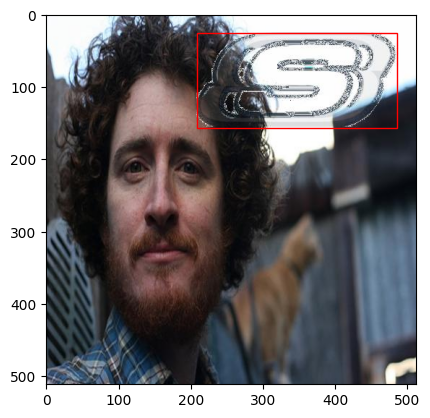

In [40]:
import matplotlib.pyplot as plt

sample = hugging_dataset['train'][1]
bbox = sample['bbox']
# plot the first image in the dataset with the bbox on it
plt.imshow(sample['image'])
plt.gca().add_patch(plt.Rectangle((bbox[0] - bbox[2] // 2, bbox[1] - bbox[3] // 2), bbox[2], bbox[3], fill=False, edgecolor='r', linewidth=1))
plt.show()

In [41]:
dataloader = DataLoader(hugging_dataset, shuffle=True)

## Training with PytorchLightning

In [53]:
class YOLOWatermarkDetection(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.yolo = YOLO('yolov8n.pt')
    
    def forward(self, x):
        return self.yolo(x)
    
    def train_dataloader(self):
        hugging_data = load_data()
        return DataLoader(hugging_data['train'], batch_size=16, shuffle=True)
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-5)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        print(x.shape, y.shape)
        y_hat = self(x)
        # convert to x1, y1, x2, y2 format, from center, width, height
        y_hat = torch.cat([y_hat[..., :2] - y_hat[..., 2:]/2, y_hat[..., :2] + y_hat[..., 2:]/2], dim=-1)
        y = torch.cat([y[..., :2] - y[..., 2:]/2, y[..., :2] + y[..., 2:]/2], dim=-1)
        # IoU loss for bounding box regression
        loss = torchvision.ops.complete_box_iou_loss(y_hat, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        # IoU loss for bounding box regression
        y_hat = torch.cat([y_hat[..., :2] - y_hat[..., 2:]/2, y_hat[..., :2] + y_hat[..., 2:]/2], dim=-1)
        y = torch.cat([y[..., :2] - y[..., 2:]/2, y[..., :2] + y[..., 2:]/2], dim=-1)
        loss = torchvision.ops.complete_box_iou_loss(y_hat, y)
        self.log('val_loss', loss)
        return loss

In [54]:
model = YOLOWatermarkDetection()
trainer = pl.Trainer(max_epochs=10)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [55]:
trainer.fit(model)

/Users/quentinfisch/Documents/EPITA/ING3/SCIA/S9/DNN/dnn-watermark/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type | Params
------------------------------
0 | yolo | YOLO | 3.2 M 
------------------------------
0         Trainable params
3.2 M     Non-trainable params
3.2 M     Total params
12.629    Total estimated model params size (MB)
/Users/quentinfisch/Documents/EPITA/ING3/SCIA/S9/DNN/dnn-watermark/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/quentinfisch/Documents/EPITA/ING3/SCIA/S9/DNN/dnn-watermark/.venv/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number 

TypeError: 'bool' object is not callable